<a href="https://colab.research.google.com/github/sh01k/teaching/blob/master/anc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**パラメータ設定**

雑音源，参照マイク，二次スピーカ，誤差マイクの位置など，パラメータを設定します。

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

#### Parameters ####
# Noise source position [m]
x_ns = -2.0

# Reference mic position [m]
x_rm = -1.0

# Loudspeaker position [m]
x_ls = 0.0

# Error mic position [m]
x_em = 2.0

# Sound speed [m/s]
c = 340

# Sampling frequency [Hz]
fs = 16000

# FFT parameters
fftlen = 1024
fftshift = int(fftlen/2)

# Time [s]
t = np.arange(fftshift)/fs

# Convolution matrix
def convmtx(v, n):
    N = len(v) + 2*n - 2
    xpad = np.concatenate([np.zeros(n-1), v[:], np.zeros(n-1)])
    X = np.zeros((len(v)+n-1, n))
    
    for i in range(n):
        X[:,i] = xpad[n-i-1:N-i]
    
    return X

**信号生成**

雑音源の信号，インパルス応答を生成し，参照マイク，誤差マイク位置での雑音源の信号を計算します。ここでは，インパルス応答は時間遅延のみとしています。

In [0]:
#### Generate signals ####
# Noise source signal
s_len = fs*8
s = np.random.rand(s_len)-0.5

# Impulse response 
h_s2r = np.sinc((t-abs(x_rm-x_ns)/c)*fs)/abs(x_rm-x_ns) # Noise source to reference mic
g = np.sinc((t-abs(x_em-x_ls)/c)*fs)/abs(x_em-x_ls) # Secondary loudspeaker to error mic
h_s2e = np.sinc((t-abs(x_em-x_ns)/c)*fs)/abs(x_em-x_ns) # Noise source to error mic

# Noise at reference mic
x_s = np.convolve(h_s2r,s)

# Noise on error mic
n = np.convolve(h_s2e,s)

# Number of frames
num_frm = int(np.floor(len(x_s)/fftlen)-1)

# Convolution matrix
g_mat = convmtx(g,fftshift*2-1);
norm2_g = np.linalg.norm(g_mat, ord=2)**2;


**適応フィルタによるANC**

Normalized least-mean-square (NLMS)アルゴリズムによる適応フィルタを用いて，ANCを行います。最後に各フレームでの誤差マイク位置でのパワーをプロットします。

Frame:  0 , Reduced noise power:  1.0
Frame:  20 , Reduced noise power:  0.1235796691597838
Frame:  40 , Reduced noise power:  0.017176610516402596
Frame:  60 , Reduced noise power:  0.0032774418325383857
Frame:  80 , Reduced noise power:  0.0009224655751136832
Frame:  100 , Reduced noise power:  0.0006450416528602429
Frame:  120 , Reduced noise power:  0.00048522610405136296


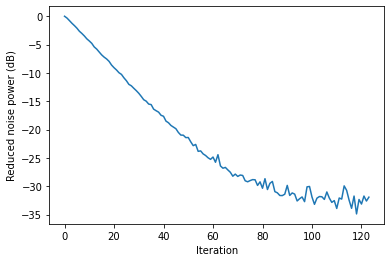

In [42]:
#### Adaptive filtering for ANC ####
# Buffer
pw_e = np.zeros(num_frm)
pw_n = np.zeros(num_frm)

d_t = np.zeros(fftshift)
d_buff = np.zeros(fftshift)

y_t = np.zeros(fftshift)
y_buff = np.zeros(fftshift)

e_t_anim = np.zeros((num_frm,fftshift))

# Initial filter
h_est = np.zeros(fftshift)

# NLMS parameters
alpha = 0.04;
beta = 1e-6;

for ii in range(num_frm):
  # Frame signal
  x_t = x_s[ii*fftshift:(ii+1)*fftshift]
  n_t = n[ii*fftshift:(ii+1)*fftshift]

  # Loudspeaker output
  dd_t = np.real(np.fft.ifft(np.fft.fft(h_est,fftlen) * np.fft.fft(x_t,fftlen)))
  d_t = dd_t[0:fftshift]+d_buff
  d_buff = dd_t[fftshift:fftlen]

  # Driving signal at error mic
  yy_t = np.real(np.fft.ifft(np.fft.fft(np.concatenate([g,np.zeros(fftshift)]),fftlen) * np.fft.fft(np.concatenate([d_t,np.zeros(fftshift)]),fftlen)))
  y_t = yy_t[0:fftshift]+y_buff
  y_buff = yy_t[fftshift:fftlen]

  # Signal at error mic
  e_t = y_t + n_t
  e_t_anim[ii,:] = e_t
  
  # Signal power of error mic and primary noise 
  pw_e[ii] = np.sum(abs(e_t)**2)
  pw_n[ii] = np.sum(abs(n_t)**2)
  
  if ii%20 == 0:
    print("Frame: ", ii, ", Reduced noise power: ", pw_e[ii]/pw_n[ii])

  # Filter update by NLMS algorithm
  g_mat_sub = g_mat[0:2*fftshift-1,:]
  e_t_pad = np.array([np.concatenate([e_t, np.zeros(fftshift-1)])]).T
  x_t_pad = np.array([np.concatenate([x_t, np.zeros(fftshift-1)])]).T
  h_grad = 2*g_mat_sub.T @ e_t_pad @ x_t_pad.T
  norm2_x = np.sum(abs(x_t)**2)
  
  for jj in range(fftshift):
    h_est = h_est - (alpha/(beta+norm2_g*norm2_x))*h_grad[jj:fftshift+jj,jj]

# Plot reduced noise power
plt.plot(10*np.log10(pw_e/pw_n))
plt.xlabel("Iteration")
plt.ylabel("Reduced noise power (dB)")
plt.show()

**誤差マイク信号の可視化**

各フレームでの誤差マイク信号が低減される様子をアニメーションで可視化します。

In [43]:
#### Animation of error mic signal ####
fig, ax = plt.subplots()
plt.close()
ax.set_xlim((t[0],t[fftshift-1]))
ax.set_ylim((-0.2,0.2))

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
  x = t[0:fftshift]
  y = e_t_anim[i]
  line.set_data(x,y)
  return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=num_frm, interval=20, blit=True)

rc('animation', html='jshtml')
anim